In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras_tuner as kt 

# Load the data
data = pd.read_csv('final_data.csv')
data = data.dropna()
data = data.drop_duplicates()
data = data.reset_index(drop=True)

# Preprocess the data like for randomForest_simplified.ipynb
# Encode the sequence
# Define the 20 standard amino acids and include non-standard ones
amino_acids = 'ACDEFGHIKLMNPQRSTVWYU'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}


def one_hot_encode(seq, max_length):
    # Pad the sequence to the maximum length with 'X' (unknown amino acid)
    padded_seq = seq.ljust(max_length, 'X')
    int_encoded = [aa_to_int.get(aa, len(amino_acids)) for aa in
                   padded_seq]  # Use a default index for unknown amino acids
    one_hot_encoded = np.zeros((max_length, len(amino_acids) + 1))  # +1 for the unknown amino acid
    for i, value in enumerate(int_encoded):
        one_hot_encoded[i, value] = 1
    return one_hot_encoded


# Determine the maximum sequence length
max_seq_length = max(data['Sequence'].apply(len))

# Encode the sequences
one_hot_encoded_sequences = np.array([one_hot_encode(seq, max_seq_length) for seq in data['Sequence']])

# Initialize the label encoder for charge states
label_encoder = LabelEncoder()
encoded_charge_states = label_encoder.fit_transform(data['Charge'].tolist())

# Reshape charge states to 3D, so that they match the dimensions of the one-hot-encoded sequences
# We repeat the charge value along the sequence length (max_seq_length) so that each sequence position has the charge value
encoded_charge_states_3d = np.repeat(encoded_charge_states[:, np.newaxis], max_seq_length, axis=1)

# Expand the charge states along the feature axis (the last axis) to match the shape of the one-hot-encoded sequences
encoded_charge_states_3d = np.expand_dims(encoded_charge_states_3d, axis=-1)

# Combine the one-hot encoded sequences and charge states into a single input array
# Concatenate along the feature axis (the last dimension)
X_combined = np.concatenate([one_hot_encoded_sequences, encoded_charge_states_3d], axis=2)

# The target variable (y) is the CCS value and will be normalized relative to the min and maximum CCS value
ccs_values = data['CCS'].values
normalized_ccs_values = (ccs_values - ccs_values.min()) / (ccs_values.max() - ccs_values.min())
y = normalized_ccs_values



In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))  # Correct input shape: (timesteps, features)
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for regression
model.compile(optimizer=Adam(0.001), loss='mean_squared_error')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping], shuffle=False)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2}")


/Users/fabianschweisthal/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.0061 - val_loss: 3.8235e-04
Epoch 2/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 7.1428e-04 - val_loss: 3.5248e-04
Epoch 3/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 6.3630e-04 - val_loss: 3.5054e-04
Epoch 4/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 6.2801e-04 - val_loss: 3.9838e-04
Epoch 5/5
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 6.0518e-04 - val_loss: 3.5355e-04
912/912 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Mean Squared Error: 0.0003535487757970796
R^2: 0.9906124525571235


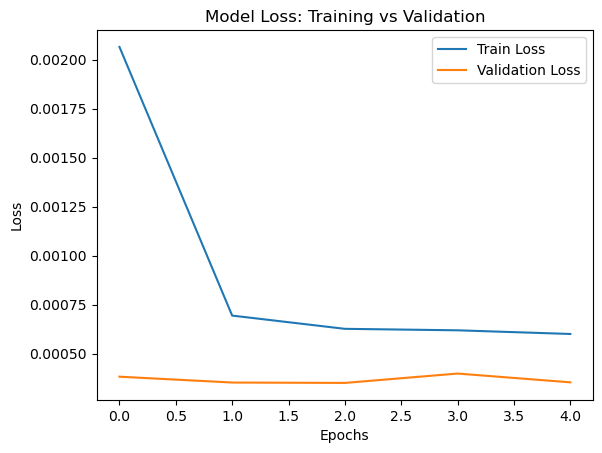

In [18]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels for the axes
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a title for clarity
plt.title('Model Loss: Training vs Validation')

# Add a legend to differentiate between train and validation losses
plt.legend()

# Display the plot
plt.show()


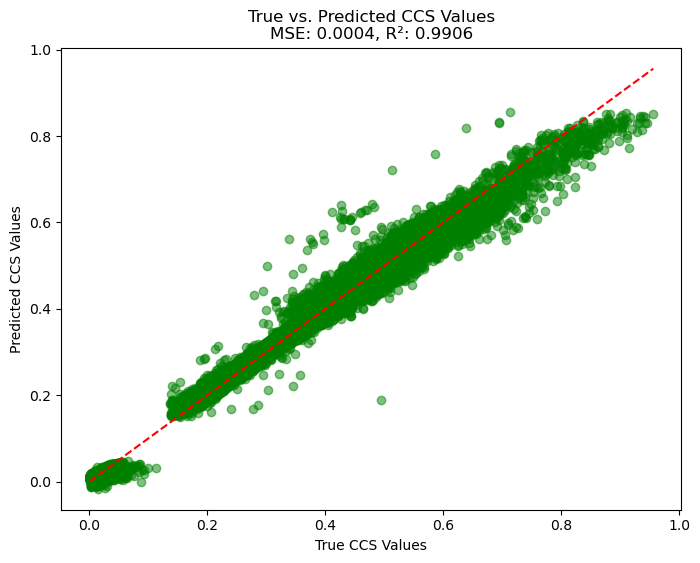

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True CCS Values')
plt.ylabel('Predicted CCS Values')
plt.title(f'True vs. Predicted CCS Values\nMSE: {mse:.4f}, R²: {r2:.4f}')
plt.show()

In [17]:

# Load and preprocess data (same as in your script)
# Ensure to use your data preparation and one-hot encoding here.

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    
    # Tune the number of LSTM units
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=16)
    model.add(LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2])))

    # Tune the dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single output for regression

    # Tune the learning rate of the Adam optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    
    return model

# Initialize the Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',  # Minimize validation loss
    max_trials=10,  # Number of hyperparameter sets to try
    executions_per_trial=1,  # Number of times to run each model (for more stability)
    directory='hyperparam_tuning',  # Folder to store tuning results
    project_name='lstm_tuning'  # Project name for organizing results
)

# Display a summary of the search space
tuner.search_space_summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Perform the hyperparameter search
tuner.search(X_train, y_train, 
             epochs=10,  # We can start with a small number of epochs for tuning
             batch_size=32,  # Can also tune batch size if needed
             validation_data=(X_test, y_test), 
             callbacks=[early_stopping],
             shuffle=False)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best LSTM Units: {best_hps.get('lstm_units')}")
print(f"Best Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

# Build and train the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(X_train, y_train, 
                         epochs=50, 
                         batch_size=32, 
                         validation_data=(X_test, y_test),
                         callbacks=[early_stopping],
                         shuffle=False)

# Evaluate the tuned model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error after tuning: {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R^2 after tuning: {r2}")

Trial 3 Complete [00h 09m 56s]
val_loss: 0.00032958900555968285

Best val_loss So Far: 0.00032397027825936675
Total elapsed time: 00h 24m 42s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
96                |64                |lstm_units
0.2               |0.1               |dropout_rate
0.01              |0.01              |learning_rate

Epoch 1/10
3646/3646 ━━━━━━━━━━━━━━━━━━━━ 62s 17ms/step - loss: 0.0097 - val_loss: 4.7067e-04
Epoch 2/10
 224/3646 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - loss: 6.4668e-04

KeyboardInterrupt: 